In [41]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy

# Work in progress
Author: Jonathan Pelham

### Introduction

This notebook is a worked example in python 3 of chapter 3 from Aircraft Design: A Conceptual Approach 3rd edition by Daniel P. Raymer. using the ASW(Anti Submarine Warface) aircraft as an example.  Where possible no libraries not in an anaconda distribution basic install will be used.
<br/><br/>
**Mission:** <br/>Fly 1500nm (2778km) at M=0.6 carrying 10000lb (4535.924kg) of equipment and 4 crew members at 800lb (363.874kg), loiter on station for 3 hrs then return.
# Takeoff Gross Weight Estimation


$$Takeoff\; Gross\; Weight = W_0\\ 
Crew\; Weight = W_{crew}\\ 
Payload\; Weight = W_{payload}\\ 
Fuel\; Weight = W_{fuel}\\ 
Aircraft\; Empty\; Weight = W_{empty}\\ 
W_0 = W_{crew} + W_{payload} + W_{fuel} + W_{empty}$$

- Simplification of the equation
$$Empty\; Weight\; Fraction = \frac{W_{empty}}{W_0}\\ 
Fuel\; Fraction = \frac{W_{fuel}}{W_0}\\
W_0 = W_{crew} + W_{payload} + (\frac{W_{fuel}}{W_0})W_0 + (\frac{W_{empty}}{W_0})W_0$$
- Solving for $W_0$ as follows
$$ W_0 - (\frac{W_{fuel}}{W_0})W_0 - (\frac{W_{empty}}{W_0})W_0 = W_{crew} + W_{payload}$$
$$W_0 = \frac{W_{crew} + W_{payload}}{1-(\frac{W_{fuel}}{W_0})-(\frac{W_{empty}}{W_0})}$$
Since $W_{crew}$ and $W_{payload}$ are normally in the aircraft design requirments this then allows us to estimate the takeoff gross weight $W_0$ of the proposed aircraft by selecting appropriate empty weight fraction $\frac{W_{empty}}{W_0}$ and fuel fractions $\frac{W_{fuel}}{W_0}$ based on historical trends and our understanding of the aircraft role based on its design requirments.







In [52]:
def TGW(EmptyW_F, Fuel_F, Crew_W, Payload_W):
    return (Crew_W+Payload_W)/(1-Fuel_F-EmptyW_F)
#e.g. ASW example
Crew_Weight = 800 #lb
Payload_Weight = 10000 #lb
Fuel_Fraction = 0.387
Empty_Weight_Fraction = 0.4361
print("Crew Weight %.2f lb" % (Crew_Weight))
print("Payload Weight %.2f lb" % (Payload_Weight))
print("Fuel Fraction %.4f" % (Fuel_Fraction,))
print("Empty Weight Fractiont %.4f" % (Empty_Weight_Fraction,))
TGW_tmp_1 = TGW(Empty_Weight_Fraction, Fuel_Fraction, Crew_Weight, Payload_Weight)
print("Takeoff Gross Weight W_0 %.2f lb" % (TGW_tmp_1))


Crew Weight 800.00 lb
Payload Weight 10000.00 lb
Fuel Fraction 0.3870
Empty Weight Fractiont 0.4361
Takeoff Gross Weight W_0 61051.44 lb


# Empty Weight Estimation
Empty weight fractions are estimated based on historical trends for aircraft based on their roles and sized takeoff weight.  Raymer suggests a $5\%$ reduction should be applied if the proposed aircraft is to be of composite construction.  He suggests that there is not yet enough information to base this reduction in a study of actual aircraft.  Perhaps by now there is such a study and this notebook will perhaps be updated to reflect that in the future.
$$Historical\; metric\; = A\\
Variable\; Wing\; Sweep\; penalty\; = K_{vs}\\
K_{vs} = 1.04\; if\; variable\; sweep\; K_{vs} = 1\; otherwise\\
 \\
Weight\; Sensitivity\; Exponent\; = C\\
\frac{W_{empty}}{W_0} = A {W_0}^C K_{vs}$$


In [53]:
def EWF(TakeoffG_W,HS_metric,WeightS_E,VWS=False,VWS_penalty=1.04):
    if VWS:
        VWS_p_factor = VWS_penalty
    else:
        VWS_p_factor = 1
        
    return HS_metric*pow(TakeoffG_W, WeightS_E)*VWS_p_factor

bomber_HS_metric = 0.93
bomber_weight_sensitivty_e = -0.07
estimated_TGW = 50000
print(EWF(estimated_TGW,bomber_HS_metric,bomber_weight_sensitivty_e))

0.436068833653


# Fuel Fraction Estimation
To estimate the fuel fraction of the aircraft we need to understand more about how it will be used to inform us regarding the rate of fuel consumption at different points during the mission and the aerodynamics.<br/>
An aircraft mission can be broken down into multiple segments.  The weight at the start of the mission is taken as the Takeoff Gross Weight $W_0$ and for each mission segment $i$ the weight of the aircraft at the end of that segment will be $W_i$.  The weight fraction of each segment is expressed as $(\frac{W_i}{W_{i-1}})$.  In a mission with a total number of segments $x$ the weight of the aircraft at the end of the mission will be $W_x$.  The ratio $\frac{W_x}{W_0}$ can then be used to calculate the fuel fraction.  In our simple sizing study we presume no other weight change apart from fuel burn occurs during the mission.  Raymer suggests a $6\%$ allowance should be made for reserve and trapped fuel.
$$\frac{W_{fuel}}{W_0} = 1.06(1 - \frac{W_x}{W_0})$$

In [54]:
def FF(mission_ratio,RT_Allowance=1.06):
    return RT_Allowance*(1-mission_ratio)

# Cruise fuel burn
Cruise weight fractions can be found by using the breguet range equation
$$Range = R\; in\; ft\\
Specific\; Fuel\; Consumption = C \\
Velocity = V\; in\; \frac{ft}{s}\\
Lift\; to\; Drag\; ratio\; = \frac{L}{D} \\
R = \frac{V}{C} \frac{L}{D} \ln(\frac{W_{i-1}}{W_i})$$

Which can be rearranged to give the weight fraction for that segment.
$$\frac{W_i}{W_{i-1}} = exp(\frac{-R C}{V (\frac{L}{D})})$$

In [55]:
def cruise_WF(Range, Specific_FC, velocity, LD_ratio):
    return numpy.exp((-1*Range*Specific_FC)/(velocity*LD_ratio))

high_bypass_turbofan_cruise_SFC = 0.0001389

# Loiter fuel burn
Loiter weight fractions can be found using the endurance equation.
$$ Endurance = E\; in\; s\\
E = \frac{\frac{L}{D}}{C}\ln(\frac{W_{i-1}}{W_i})$$
Rearranged again to put it in terms of the weight fraction we get
$$\frac{W_i}{W_{i-1}} = exp(\frac{-E C}{(\frac{L}{D})})$$

In [56]:
def loiter_WF(Endurance, Specific_FC, LD_ratio):
    return numpy.exp((-1*Endurance*Specific_FC)/(LD_ratio))

high_bypass_turbofan_loiter_SFC = 0.0001111

# L/D Ratio esimation

Raymer suggests that during initial sizing for a jet aircraft the cruise L/D should be taken as 86.6% of the maximum L/D of the aircraft.  The loiter L/D ratio will of course be the maxium L/D as loiter is done in the most efficent configuration to ensure as much time on station as possible.

This then leavs us with the problem of estimating L/D.
Raymer suggests estimating it based on the wetted aspect ratio of the aircraft.  This then leaves us to use the conceptual sketch which has been done of the ASW aircraft concept Raymer use as an example and he gives the wetted area ratio $\frac{S_{wet}}{S_{ref}}$ as 5.5 and the wetted aspect ratio is 1.27.  Looking up these values on the figure he provides on page 26 gives us our design L/D max of 16.

In [57]:
class AircraftMission:
    variable_stan_disp = {'name':{'description':'Name:','format':'%s'},
                         'weight_fraction':{'description':'WF:','format':'%.4f'},
                         'description':{'description':'Description:','format':'%s'},
                         'segment':{'description':'Segment:','format':'%i'}}
    def __init__(self):
        self.segments=[]
    
    def append_segment(self, seg_name, seg_WF, seg_description='None Provided'):
        no_of_segments = len(self.segments)
        self.segments.append({'segment':no_of_segments+1,'name':seg_name,'weight_fraction':seg_WF,'description':seg_description})
    
    def mission_weight_ratio(self):
        no_of_segments = len(self.segments)
        if no_of_segments <= 0:
            raise ValueError('No mission segments have been added to the mission!')
        
        mwr = 1
        for a in range(0,no_of_segments):
            mwr = mwr*self.segments[a]['weight_fraction']
        return mwr
    
    def landing_weight(self, TakeoffG_W):
        return TakeoffG_W * self.mission_weight_ratio()
    
    def display_mission(self,itp=['segment','name','weight_fraction','description'],p_dict=variable_stan_disp):
        no_of_segments = len(self.segments)
        if no_of_segments <= 0:
            raise ValueError('No mission segments have been added to the mission!')
        
        for a in range(0,no_of_segments):
            disp_list = [p_dict[item_a]['description']+p_dict[item_a]['format']+' ' for item_a in itp]
            variable_list = [self.segments[a][item_b] for item_b in itp]
            disp_string = ''.join(disp_list) % tuple(variable_list)
            print(disp_string)
            
        
        
    
    
    

In [58]:

ASW_LD_max = 16
cruise_LD_ratio = ASW_LD_max * 0.866
loiter_LD_ratio = ASW_LD_max
cruise_velocity = 596.9 # ft/s
cruise_SFC = high_bypass_turbofan_cruise_SFC
loiter_SFC = high_bypass_turbofan_loiter_SFC
mission_loiter = 10800 # 3h in s
landing_loiter = 1200 # 20 min in s
cruise_range = 9114000 # 1500nm in ft

ASW_Mission = AircraftMission()
ASW_Mission.append_segment('Warmup and Takeoff',0.97)
ASW_Mission.append_segment('Climb',0.985)
ASW_Mission.append_segment('Cruise',cruise_WF(cruise_range,cruise_SFC,cruise_velocity,cruise_LD_ratio),seg_description='1500 nm range') 
ASW_Mission.append_segment('Loiter',loiter_WF(mission_loiter,loiter_SFC,loiter_LD_ratio),seg_description='3 hr Loiter') 
ASW_Mission.append_segment('Cruise',cruise_WF(cruise_range,cruise_SFC,cruise_velocity,cruise_LD_ratio),seg_description='1500 nm range') # 1500 nm
ASW_Mission.append_segment('Loiter',loiter_WF(landing_loiter,loiter_SFC,loiter_LD_ratio),seg_description='20 minute loiter') #20 mins
ASW_Mission.append_segment('Land',0.995)
ASW_Mission.display_mission()

MWR_tmp = ASW_Mission.mission_weight_ratio()
print("Misson Weight Ratio %.4f" % (MWR_tmp,))
FF_tmp = FF(MWR_tmp)
print("Fuel Fraction %.4f" % (FF_tmp,))
TakeoffG_W_estimate = 50000
EWF_tmp = EWF(TakeoffG_W_estimate,0.93,-0.07)
print("Empty Weight Fraction %.5f based on TGW W_0 estimate %.3f lb" % (EWF_tmp,TakeoffG_W_estimate))
TGW_tmp = TGW(EWF_tmp , FF_tmp, Crew_Weight, Payload_Weight)
print("Takeoff Gross Weight W_0 %.3f lb"  % (TGW_tmp))
LGW_tmp = ASW_Mission.landing_weight(TGW_tmp)
print("Landing Gross Weight W_x %.3f lb"  % (LGW_tmp))
fuel_burn = TGW_tmp-LGW_tmp
print("Fuel Burned %.3f lb"  % (fuel_burn))


    
def calc_WG0(WGV,Fuel_F,Crew_W, Payload_W, HS_metric,WeightS_E,VWS=False,VWS_penalty=1.04):
    EWF_calc = EWF(WGV,HS_metric,WeightS_E,VWS=False,VWS_penalty=1.04)
    return TGW(EWF_calc, Fuel_F, Crew_W, Payload_W)

def diff_calc_WG0(WGV,Fuel_F,Crew_W, Payload_W, HS_metric,WeightS_E,VWS=False,VWS_penalty=1.04):
    tmp_wgv = calc_WG0(WGV,Fuel_F,Crew_W, Payload_W, HS_metric,WeightS_E,VWS,VWS_penalty)
    result = WGV - tmp_wgv
    if result < 0:
        mag_result = result * -1
    else:
        mag_result=result
    return mag_result
    

def calc_WG0_array(WGV_list,Fuel_F,Crew_W, Payload_W, HS_metric,WeightS_E,VWS=False,VWS_penalty=1.04):
    WG0_array=[]
    EWF_array=[]
    diff_array=[]
    for a in range(0,len(WGV_list)):
        WG0_array.append(calc_WG0(WGV_list[a],Fuel_F,Crew_W, Payload_W, HS_metric,WeightS_E,VWS,VWS_penalty))
        EWF_array.append(EWF(WGV_list[a],HS_metric,WeightS_E,VWS=False,VWS_penalty=1.04))
        diff_array.append(diff_calc_WG0(WGV_list[a],Fuel_F,Crew_W, Payload_W, HS_metric,WeightS_E,VWS,VWS_penalty))
    return WG0_array, EWF_array, diff_array

Segment:1 Name:Warmup and Takeoff WF:0.9700 Description:None Provided 
Segment:2 Name:Climb WF:0.9850 Description:None Provided 
Segment:3 Name:Cruise WF:0.8581 Description:1500 nm range 
Segment:4 Name:Loiter WF:0.9278 Description:3 hr Loiter 
Segment:5 Name:Cruise WF:0.8581 Description:1500 nm range 
Segment:6 Name:Loiter WF:0.9917 Description:20 minute loiter 
Segment:7 Name:Land WF:0.9950 Description:None Provided 
Misson Weight Ratio 0.6440
Fuel Fraction 0.3773
Empty Weight Fraction 0.43607 based on TGW W_0 estimate 50000.000 lb
Takeoff Gross Weight W_0 57882.726 lb
Landing Gross Weight W_x 37277.185 lb
Fuel Burned 20605.540 lb


Now that we have created a function for the the formulas and a way to store and interrogate mission profiles we can find the ideal $W_0$ using the iteration method Raymer shows. 

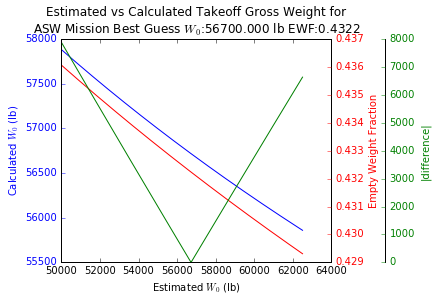

In [59]:
WGV_array = [50000]
for a in range(0,250):
    WGV_array.append(WGV_array[a]+50)
    
calc_WG0_tmp, calc_EWF_tmp, diff_array = calc_WG0_array(WGV_array,FF_tmp,Crew_Weight, Payload_Weight, bomber_HS_metric,bomber_weight_sensitivty_e)
best_guess_index = numpy.argmin(diff_array)
fig, ax = plt.subplots()
axes = [ax, ax.twinx(), ax.twinx()]
fig.subplots_adjust(right=0.75)
axes[-1].spines['right'].set_position(('axes', 1.2))
axes[0].plot(WGV_array,calc_WG0_tmp,c='b')
axes[0].set_title('Estimated vs Calculated Takeoff Gross Weight for\nASW Mission Best Guess $W_0$:%.3f lb EWF:%.4f' % (WGV_array[best_guess_index],calc_EWF_tmp[best_guess_index]))
axes[0].set_ylabel('Calculated $W_0$ (lb)',color='b')
axes[0].set_xlabel('Estimated $W_0$ (lb)')
axes[0].tick_params('y', colors='b')
axes[1].plot(WGV_array,calc_EWF_tmp,c='r')
axes[1].set_ylabel('Empty Weight Fraction',color='r')
axes[1].tick_params('y', colors='r')
axes[2].plot(WGV_array,diff_array,c='g')
axes[2].set_ylabel('|difference|',color='g')
axes[2].tick_params('y', colors='g')
plt.show()

# Optimisation
In contrast to the method expressed in Raymers book because we have expressed the formulas as python functions we can use the powerful optimisation methods available to us.  Here we use the scipy library minimize method to efficently find the ideal $W_0$ for the mission as defined.

Because python has these libraries it makes it much easier to create functions that call other functions and explore the solution space to create optimal aircraft designs.



In [60]:
import scipy.optimize as optimize
minimum_W_0 = optimize.minimize(diff_calc_WG0,50000, args = (FF_tmp,Crew_Weight, Payload_Weight, bomber_HS_metric,bomber_weight_sensitivty_e))
min_EWF = EWF(minimum_W_0.x,0.93,-0.07)
print("Optimised Takeoff Gross Weight W_0 found %.3f lb with EWF %.4f" % (minimum_W_0.x,min_EWF))

Optimised Takeoff Gross Weight W_0 found 56718.073 lb with EWF 0.4322


In [ ]:
print('Difference between the Takeoff Gross Weight W_0 estimations: {} lbs'.format((WGV_array[best_guess_index] - minimum_W_0.x)[0]))
print('Difference between the Empty Weight Fraction EWF estimations: {} %'.format(100*((calc_EWF_tmp[best_guess_index] - min_EWF)[0])))